In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy as sp
import akantu as aka
import matplotlib.pyplot as plt

from helper import get_theoretical_normal_displacement, get_theoretical_contact_radius, plot_mesh
from contact_mechanics_internodes import ContactMechanicsInternodes

In [4]:
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{eulervm}',
    'font.family': 'serif',
    'font.serif': 'Palatino',
    'font.size': 11})

## 3D sphere

In [5]:
# Set up contact problem
mesh_file = 'mesh/contact3d_sphere.msh'
material_file = 'material/material.dat'
spatial_dimension = 3
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

# Apply boundary conditions
model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._z), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.1, aka._y), 'secondary_fixed')
model.applyBC(aka.FixedValue(0., aka._z), 'primary_fixed')

# Run internodes algorithm
d0 = 0.05
R = 0.5

E = model.getMaterial(0).getReal("E")
nu = model.getMaterial(0).getReal("nu")

d_list = np.linspace(0.05, 0.25, 10)
a_list = np.empty_like(d_list)
u_list = np.empty_like(d_list)

for j, d in enumerate(d_list):

    model.applyBC(aka.FixedValue(-d+d0, aka._y), 'secondary_fixed')

    # Get positions of all nodes, surface connectivity and candidate nodes
    nodal_positions = mesh.getNodes()
    surface_connectivity = mesh.getConnectivity(aka._triangle_3)
    nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
    nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()
    external_force = model.getExternalForce()
    nodal_displacements = model.getDisplacement()
    nodes_blocked = model.getBlockedDOFs()

    model.assembleMass()
    M = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('M')).toarray()

    model.assembleStiffnessMatrix()
    K = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('K')).toarray()

    E = model.getMaterial(0).getReal("E")

    # Set initial conditions
    internodes_model = ContactMechanicsInternodes(spatial_dimension, nodal_positions, nodal_displacements, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary, nodes_blocked, external_force, M, K, E)
    
    max_iter = 10
    for i in range(max_iter):
        # Find the interface nodes
        internodes_model.define_interface()

        # Assemble model
        internodes_model.assemble_full_model()

        # Solve model
        displacements, lambdas = internodes_model.solve_direct()

        # Update the interface nodes and check if it converged
        converged = internodes_model.update_interface(displacements, lambdas)

        if converged:
            break

    assert i+1 < max_iter

    positions = internodes_model.nodal_positions + displacements
    positions_interface_secondary = positions[internodes_model.nodes_interface_secondary]

    a_list[j] = np.max(sp.spatial.distance.cdist(positions_interface_secondary, positions_interface_secondary))/2
    u_list[j] = np.min(positions_interface_secondary[:, 1])


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


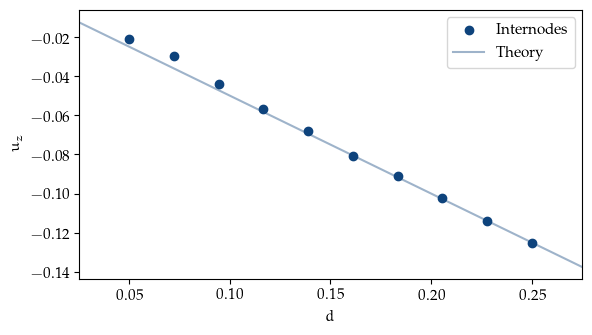

In [6]:
plt.figure(figsize=(6.5, 3.5))
plt.ylabel(r'$u_z$')
plt.xlabel(r'$d$')
plt.scatter(d_list, u_list, color='#0e437c', label='Internodes')
d_list_refined = np.linspace(0.025, 0.275, 100)
plt.plot(d_list_refined, get_theoretical_normal_displacement(R, d_list_refined, E, nu), color='#0e437c', alpha=0.4, label='Theory')
plt.legend()
plt.xlim([0.025, 0.275])
plt.savefig('report/plots/normal_displacement_3d.pgf', bbox_inches='tight')
plt.show()

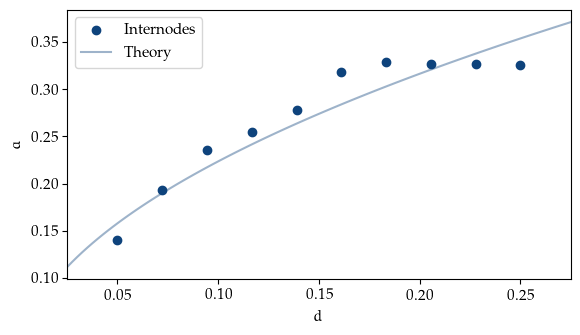

In [8]:
plt.figure(figsize=(6.5, 3.5))
plt.ylabel(r'$a$')
plt.xlabel(r'$d$')
plt.scatter(d_list, a_list, color='#0e437c', label='Internodes')
d_list_refined = np.linspace(0.025, 0.275, 100)
plt.plot(d_list_refined, get_theoretical_contact_radius(R, d_list_refined), color='#0e437c', alpha=0.4, label='Theory')
plt.xlim([0.025, 0.275])
plt.legend()
plt.savefig('report/plots/contact_radius_3d.pgf', bbox_inches='tight')
plt.show()

## 2D circle

In [111]:
# Set up contact problem
mesh_file = 'mesh/contact2d_circle.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

# Apply boundary conditions
model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.1, aka._y), 'secondary_fixed')

# Run internodes algorithm
d0 = 0.05
R = 0.5

E = model.getMaterial(0).getReal("E")
nu = model.getMaterial(0).getReal("nu")

d_list = np.linspace(0.05, 0.25, 5)
a_list = np.empty_like(d_list)
u_list = np.empty_like(d_list)

for j, d in enumerate(d_list):

    model.applyBC(aka.FixedValue(-d+d0, aka._y), 'secondary_fixed')

    # Get positions of all nodes, surface connectivity and candidate nodes
    nodal_positions = mesh.getNodes()
    surface_connectivity = mesh.getConnectivity(aka._segment_2)
    nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
    nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()
    external_force = model.getExternalForce()
    nodal_displacements = model.getDisplacement()
    nodes_blocked = model.getBlockedDOFs()

    model.assembleMass()
    M = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('M')).toarray()

    model.assembleStiffnessMatrix()
    K = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('K')).toarray()

    E = model.getMaterial(0).getReal("E")

    # Set initial conditions
    internodes_model = ContactMechanicsInternodes(spatial_dimension, nodal_positions, nodal_displacements, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary, nodes_blocked, external_force, M, K, E)
    
    max_iter = 10
    for i in range(max_iter):
        # Find the interface nodes
        internodes_model.define_interface()

        # Assemble model
        internodes_model.assemble_full_model()

        # Solve model
        displacements, lambdas = internodes_model.solve_direct()

        # Update the interface nodes and check if it converged
        converged = internodes_model.update_interface(displacements, lambdas)

        if converged:
            break

    assert i+1 < max_iter

    positions = internodes_model.nodal_positions + displacements
    positions_interface_secondary = positions[internodes_model.nodes_interface_secondary]

    a_list[j] = np.max(sp.spatial.distance.cdist(positions_interface_secondary, positions_interface_secondary))/2
    u_list[j] = np.min(positions_interface_secondary[:, 1])


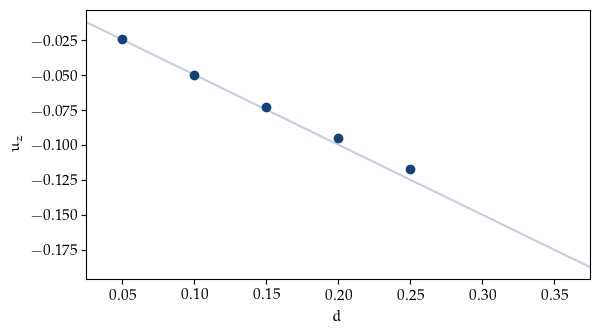

In [112]:
plt.figure(figsize=(6.5, 3.5))
plt.ylabel(r'$u_z$')
plt.xlabel(r'$d$')
plt.scatter(d_list, u_list, color='#0e437c')
d_list_refined = np.linspace(0.025, 0.375, 100)
plt.xlim([0.025, 0.375])
plt.plot(d_list_refined, get_theoretical_normal_displacement(R, d_list_refined, E, nu), color='#0e437c', alpha=0.25)
plt.savefig('report/plots/normal_displacement_2d.pgf', bbox_inches='tight')
plt.show()

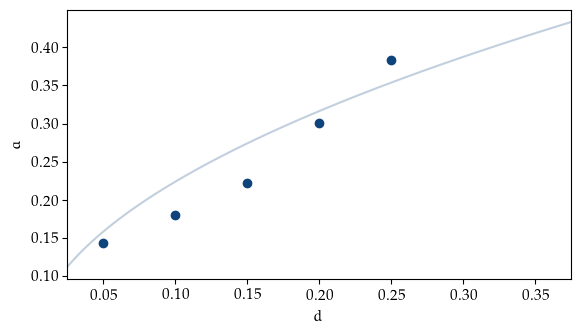

In [113]:
plt.figure(figsize=(6.5, 3.5))
plt.ylabel(r'$a$')
plt.xlabel(r'$d$')
plt.scatter(d_list, a_list, color='#0e437c')
d_list_refined = np.linspace(0.025, 0.375, 100)
plt.xlim([0.025, 0.375])
plt.plot(d_list_refined, get_theoretical_contact_radius(R, d_list_refined), color='#0e437c', alpha=0.25)
plt.savefig('report/plots/contact_radius_2d.pgf', bbox_inches='tight')
plt.show()

## Explain method

----> Starting iteration 1 <----


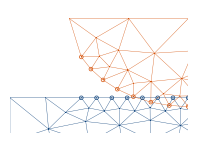

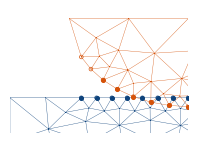

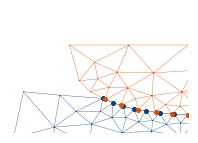

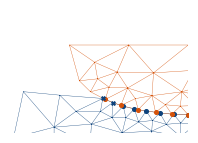

----> Starting iteration 2 <----


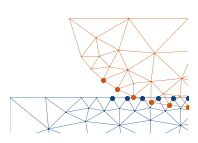

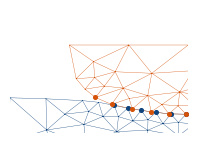

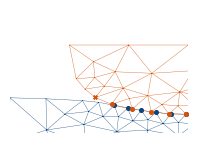

----> Starting iteration 3 <----


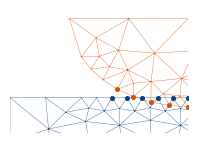

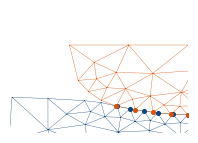

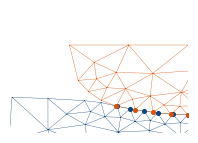


successfully converged in 3 iterations


In [10]:
mesh_file = 'mesh/contact2d_circle_example.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.15, aka._y), 'secondary_fixed')

# Get positions of all nodes, surface connectivity and candidate nodes
nodal_positions = mesh.getNodes()
surface_connectivity = mesh.getConnectivity(aka._segment_2)
nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()
external_force = model.getExternalForce()
nodal_displacements = model.getDisplacement()
nodes_blocked = model.getBlockedDOFs()

model.assembleMass()
M = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('M')).toarray()

model.assembleStiffnessMatrix()
K = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('K')).toarray()

E = model.getMaterial(0).getReal("E")

# Set initial conditions
internodes_model = ContactMechanicsInternodes(spatial_dimension, nodal_positions, nodal_displacements, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary, nodes_blocked, external_force, M, K, E)

# Plot initial configuration

max_iter = 10
for i in range(max_iter):
    print("----> Starting iteration", i+1, "<----")

    if i == 0:
        plot_mesh(internodes_model.nodal_positions,
                mesh.getConnectivity(aka._triangle_3),
                mesh.getElementGroup('primary').getNodeGroup().getNodes().ravel(),
                mesh.getElementGroup('secondary').getNodeGroup().getNodes().ravel(),
                internodes_model.nodes_interface_primary,
                internodes_model.nodes_interface_secondary,
                savename='report/plots/example_initial.pgf')

    # Find the interface nodes
    internodes_model.define_interface()

    if i == 0:
        plot_mesh(internodes_model.nodal_positions,
                mesh.getConnectivity(aka._triangle_3),
                mesh.getElementGroup('primary').getNodeGroup().getNodes().ravel(),
                mesh.getElementGroup('secondary').getNodeGroup().getNodes().ravel(),
                internodes_model.nodes_candidate_primary,
                internodes_model.nodes_candidate_secondary,
                internodes_model.nodes_interface_primary,
                internodes_model.nodes_interface_secondary,
                savename='report/plots/example_iter' + str(i) + '_interface.pgf')
    else: 
        plot_mesh(internodes_model.nodal_positions,
                mesh.getConnectivity(aka._triangle_3),
                mesh.getElementGroup('primary').getNodeGroup().getNodes().ravel(),
                mesh.getElementGroup('secondary').getNodeGroup().getNodes().ravel(),
                None,
                None,
                internodes_model.nodes_interface_primary,
                internodes_model.nodes_interface_secondary,
                savename='report/plots/example_iter' + str(i) + '_interface.pgf')

    # Assemble model
    internodes_model.assemble_full_model()

    # Solve model
    displacements, lambdas = internodes_model.solve_direct()

    plot_mesh(internodes_model.nodal_positions + displacements,
        mesh.getConnectivity(aka._triangle_3),
        mesh.getElementGroup('primary').getNodeGroup().getNodes().ravel(),
        mesh.getElementGroup('secondary').getNodeGroup().getNodes().ravel(),
        None,
        None,
        internodes_model.nodes_interface_primary,
        internodes_model.nodes_interface_secondary,
                savename='report/plots/example_iter' + str(i) + '_solution.pgf')

    # Update the interface nodes and check if it converged
    converged, nodes_added_primary, nodes_added_secondary, nodes_dumped_primary, nodes_dumped_secondary = internodes_model.update_interface(displacements, lambdas, return_changes=True)

    # Plot the obtained solution
    plot_mesh(internodes_model.nodal_positions + displacements,
        mesh.getConnectivity(aka._triangle_3),
        mesh.getElementGroup('primary').getNodeGroup().getNodes().ravel(),
        mesh.getElementGroup('secondary').getNodeGroup().getNodes().ravel(),
        None,
        None,
        internodes_model.nodes_interface_primary,
        internodes_model.nodes_interface_secondary,
        nodes_added_primary,
        nodes_added_secondary,
        nodes_dumped_primary,
        nodes_dumped_secondary,
                savename='report/plots/example_iter' + str(i) + '_dumping.pgf')

    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break